# Conditional Routing in LangGraph

In LangGraph, conditional routing allows the dynamic determination of the next node(s) to execute based on the current state.

This is achieved using conditional edges, which evaluate a function using certain defined logic, to decide the subsequent path in the graph.

This mechanism enables the creation of adaptable workflows that respond to varying conditions during execution. Let's dive deep into conditional routing in this demo.

![](https://i.imgur.com/uX12AyO.png)

## Install Dependencies

In [1]:
!pip install langchain==0.3.14
!pip install langgraph==0.2.66

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.9/326.9 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.0
    Uninstalling langsmith-0.3.0:
      Successfully uninstalled langsmith-0.3.0
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.15
    Uninstalling langchain-0.3.15:
      Successfully uninstalled langchain-0.3.15
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.3/145.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.2 MB/s eta 0:00:00


## Creating the Graph with Conditional Edges

[Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) connect the nodes.

Normal Edges are used if you want to *always* go from, for example, `node_1` to `node_2`.

[Conditional Edges](https://langchain-ai.github.io/langgraph/reference/graphs/?h=conditional+edge#langgraph.graph.StateGraph.add_conditional_edges) are used want to *optionally* route between nodes.

Conditional edges are implemented as functions that return the next node to visit based upon some logic.

![](https://i.imgur.com/uX12AyO.png)

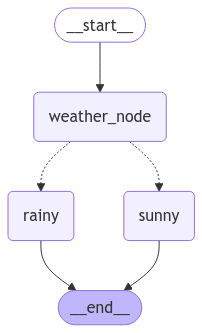

In [2]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Define the state structure
class State(TypedDict):
    weather: str

# Initialize the StateGraph
graph_builder = StateGraph(State)

# Define node functions
def weather_node(state: State) -> State:
    print("Checking the weather...")
    return state  # Just pass the state along

def rainy_node(state: State) -> State:
    print("It's rainy. Take an umbrella!")
    return state

def sunny_node(state: State) -> State:
    print("It's sunny. Wear sunglasses!")
    return state

# Define the routing function
def weather_routing(state: State) -> str:
    if state['weather'] == 'rainy':
        return "rainy" # name of the rainy node
    elif state['weather'] == 'sunny':
        return "sunny" # name of the sunny node
    else:
        raise ValueError("Invalid weather condition!")

# Add nodes to the graph
graph_builder.add_node("weather_node", weather_node)
graph_builder.add_node("rainy", rainy_node)
graph_builder.add_node("sunny", sunny_node)

# Define edges
graph_builder.add_edge(START, "weather_node")
graph_builder.add_conditional_edges("weather_node",
                                    # the routing function will route to the rainy node if weather state is 'rainy'
                                    # the routing function will route to the sunny node if the weather state is 'sunny'
                                    weather_routing, # routing function
                                    ["rainy", "sunny"] # possible nodes where the routing function can end up going
                                   )
graph_builder.add_edge("rainy", END)
graph_builder.add_edge("sunny", END)

# Compile the graph
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
# Execute the graph with an initial state for "rainy"
print("\n--- Rainy Condition ---")
initial_state_rainy = {"weather": "rainy"}
result_rainy = graph.invoke(initial_state_rainy)


--- Rainy Condition ---
Checking the weather...
It's rainy. Take an umbrella!


In [4]:
# Execute the graph with an initial state for "sunny"
print("\n--- Sunny Condition ---")
initial_state_sunny = {"weather": "sunny"}
result_sunny = graph.invoke(initial_state_sunny)


--- Sunny Condition ---
Checking the weather...
It's sunny. Wear sunglasses!


In [5]:
# Execute the graph with an initial state for "sunny"
print("\n--- Sunny Condition ---")
initial_state_sunny = {"weather": "humid"}
result_sunny = graph.invoke(initial_state_sunny)


--- Sunny Condition ---
Checking the weather...


ValueError: Invalid weather condition!

## Conditional Routing with More Nodes

The more nodes you have for custom logic you just need to define the node functions and then put in relevant conditions for the function which would do the conditional routing as shown in the example below.

![](https://i.imgur.com/uvZeLV3.png)

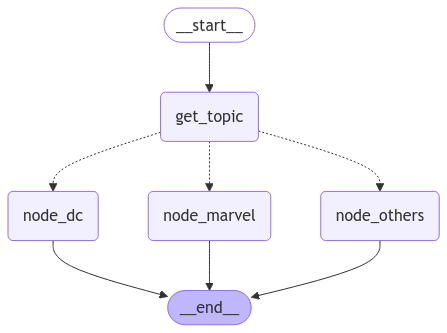

In [6]:
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]
    topic: str


def get_topic(state: State) -> str:
    topic = state['messages'][0].content
    print(f"---Getting topic: {topic}---")
    return {"topic": topic}

def decide_route(state: State) -> State:
    print("---Conditional Routing---")
    topic = state['topic']
    print(topic)
    if topic.lower() in ['batman', 'superman']:
        return "node_dc"
    if topic.lower() in ['spiderman', 'avengers']:
        return "node_marvel"
    return "node_others"

def node_dc(state):
    print("---Node DC Comics---")
    topic = state['topic']
    return {"messages": "Hello yes happy to show you comics of: "+topic}

def node_marvel(state):
    print("---Node Marvel Comics---")
    topic = state['topic']
    return {"messages": "Hello yes happy to show you comics of: "+topic}

def node_others(state):
    print("---Node Others---")
    topic = state['topic']
    return {"messages": "Sorry we do not have: "+topic}


# Build graph
builder = StateGraph(State)
builder.add_node("get_topic", get_topic)
builder.add_node("node_dc", node_dc)
builder.add_node("node_marvel", node_marvel)
builder.add_node("node_others", node_others)

# Logic
builder.add_edge(START, "get_topic")
builder.add_conditional_edges("get_topic",
                              decide_route,
                              ["node_dc", "node_marvel", "node_others"]
                              )
builder.add_edge("node_dc", END)
builder.add_edge("node_marvel", END)
builder.add_edge("node_others", END)


# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
def call_agent(agent, topic):
    msgs = agent.invoke({"messages": topic})
    print(msgs['messages'][-1].content)


In [8]:
call_agent(graph, "Batman")

---Getting topic: Batman---
---Conditional Routing---
Batman
---Node DC Comics---
Hello yes happy to show you comics of: Batman


In [9]:
call_agent(graph, "avengers")

---Getting topic: avengers---
---Conditional Routing---
avengers
---Node Marvel Comics---
Hello yes happy to show you comics of: avengers


In [10]:
call_agent(graph, "Venom")

---Getting topic: Venom---
---Conditional Routing---
Venom
---Node Others---
Sorry we do not have: Venom
